<a href="https://colab.research.google.com/github/suyashmarathe512/suyash/blob/main/LLM_Powered_Booking_Analytics_%26_QA_System/LLM_Powered_Booking_Analytics_%26_QA_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastapi uvicorn nest-asyncio pyngrok sentence-transformers faiss-cpu pandas numpy matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
import nest_asyncio
from pyngrok import ngrok

# For FAISS and SentenceTransformer
import faiss
from sentence_transformers import SentenceTransformer

In [6]:
############################
# Section 1: Data Preprocessing
############################

def load_and_clean_data(csv_url: str) -> pd.DataFrame:
    """
    Load data from a CSV URL and perform cleaning:
      - Convert date columns to datetime.
      - Fill missing numeric values with median.
      - Fill missing categorical values with mode.
      - Compute revenue using 'adr', 'stays_in_week_nights', and 'stays_in_weekend_nights'.
    """
    df = pd.read_csv(csv_url)

    # Convert reservation date to datetime if present
    if 'reservation_status_date' in df.columns:
        df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

    # Fill missing numeric columns with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill missing categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Compute revenue if required columns exist
    if {'adr', 'stays_in_week_nights', 'stays_in_weekend_nights'}.issubset(df.columns):
        df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
        df['revenue'] = df['adr'] * df['total_nights']
    else:
        df['revenue'] = 0

    return df

# Example CSV URL (you can replace it with your own if needed)
CSV_URL = "https://solvei8-aiml-assignment.s3.ap-southeast-1.amazonaws.com/hotel_bookings.csv"
df = load_and_clean_data(CSV_URL)
print(df.head())

<ipython-input-6-1048c3d1a0c0>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
<ipython-input-6-1048c3d1a0c0>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-6-1048c3d1a0c0>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  company  \
0                        0                     0       2  ...    179.0   
1               

In [7]:
############################
# Section 2: Analytics & Reporting
############################

def compute_revenue_trends(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute monthly revenue trends based on the computed revenue and reservation date.
    """
    df['month'] = df['reservation_status_date'].dt.to_period('M')
    revenue_trend = df.groupby('month')['revenue'].sum().reset_index()
    return revenue_trend

def calculate_cancellation_rate(df: pd.DataFrame) -> float:
    """
    Calculate the cancellation rate as a percentage.
    """
    cancellation_rate = df['is_canceled'].mean() * 100
    return cancellation_rate

def get_lead_time_stats(df: pd.DataFrame) -> dict:
    """
    Return descriptive statistics for the booking lead time.
    """
    return df['lead_time'].describe().to_dict()

def get_geographical_distribution(df: pd.DataFrame) -> dict:
    """
    Calculate the distribution of bookings by country.
    """
    distribution = df['country'].value_counts().to_dict()
    return distribution

def get_average_price(df: pd.DataFrame) -> float:
    """
    Calculate the average price (ADR) for hotel bookings.
    """
    return df['adr'].mean()

def get_total_revenue_for_hotel(df: pd.DataFrame, hotel_name: str) -> float:
    """
    Calculate total revenue for a specific hotel.
    """
    hotel_data = df[df['hotel'].str.lower() == hotel_name.lower()]
    return hotel_data['revenue'].sum()

def get_revenue_in_date_range(df: pd.DataFrame, start_date: str, end_date: str) -> float:
    """
    Calculate total revenue between two dates (YYYY-MM-DD format).
    """
    mask = (df['reservation_status_date'] >= start_date) & (df['reservation_status_date'] <= end_date)
    return df.loc[mask, 'revenue'].sum()

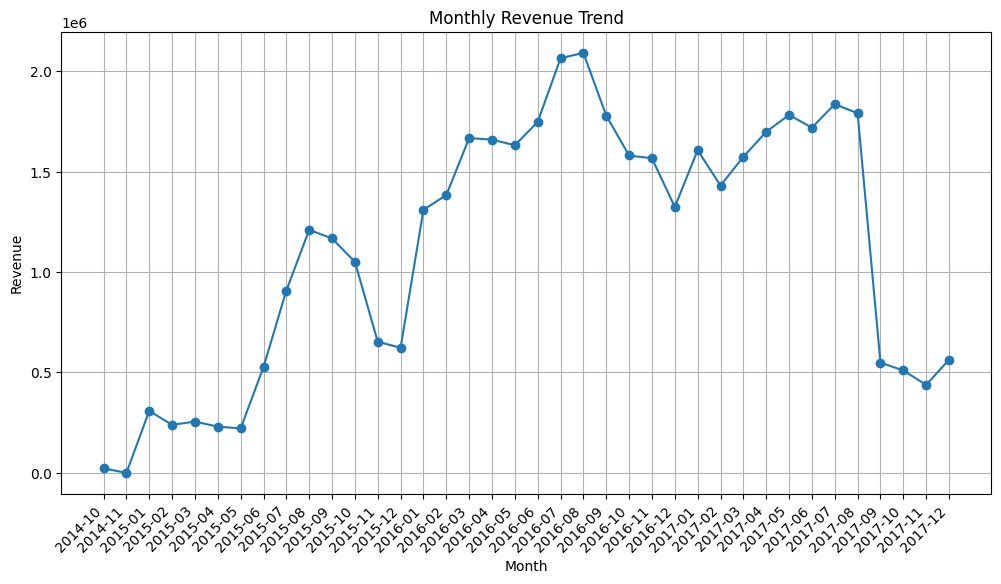

In [8]:
##############################
# section : visualization
###############################
# Create the plot
revenue_trend = compute_revenue_trends(df)
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(revenue_trend['month'].astype(str), revenue_trend['revenue'], marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

Text(0.5, 1.0, 'Cancellation Rate')

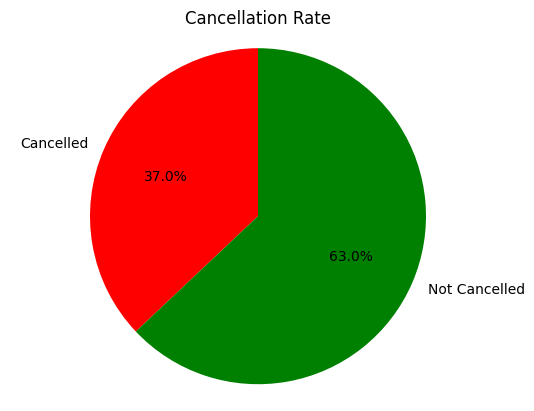

In [9]:

cancellation_rate = calculate_cancellation_rate(df)

labels = ['Cancelled', 'Not Cancelled']
sizes = [cancellation_rate, 100 - cancellation_rate]
colors = ['red', 'green']

# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Cancellation Rate')



{'count': 119390.0, 'mean': 104.01141636652986, 'std': 106.86309704798579, 'min': 0.0, '25%': 18.0, '50%': 69.0, '75%': 160.0, 'max': 737.0}


Text(0, 0.5, 'Frequency')

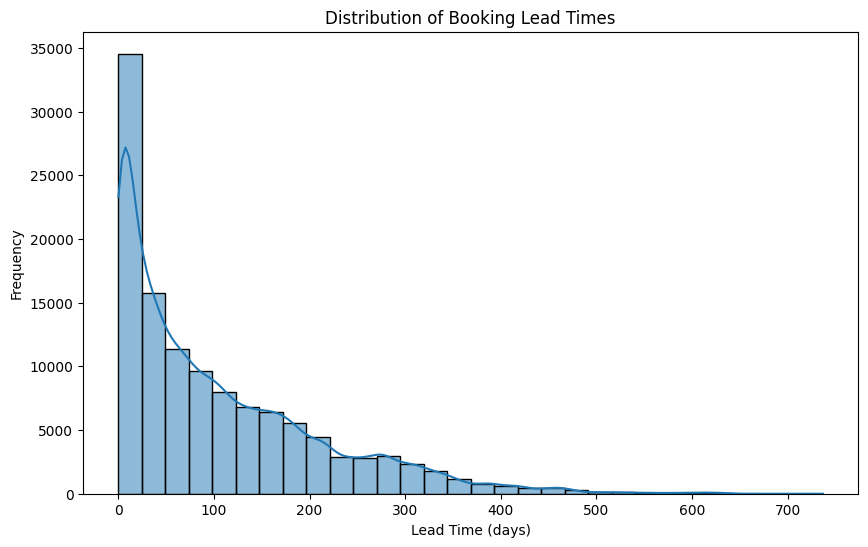

In [10]:
lead_time_stats = get_lead_time_stats(df)
print(lead_time_stats)
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time'], bins=30, kde=True)
plt.title('Distribution of Booking Lead Times')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')

Text(0, 0.5, 'ADR')

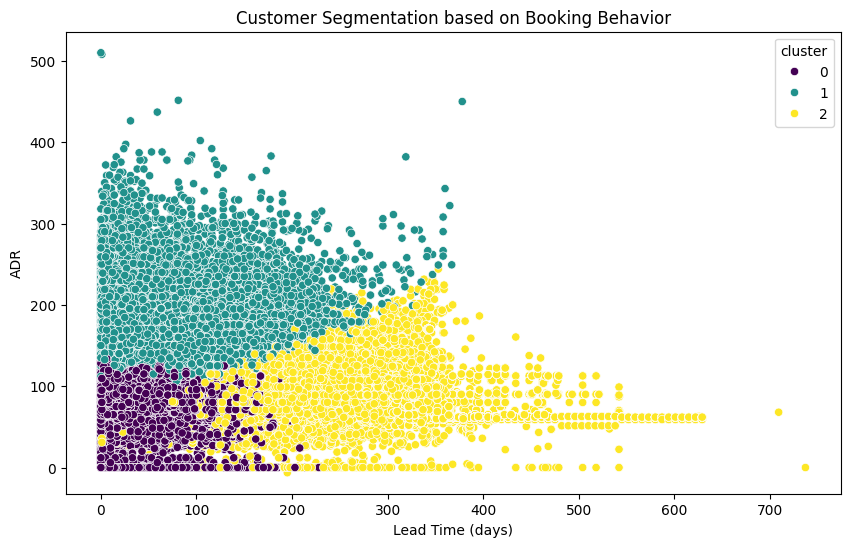

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

  # Select features for clustering
features = df[['lead_time', 'adr', 'total_nights']]

  # Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

  # Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)
df = df[df['adr'] < 1000] #due to outliers.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lead_time', y='adr', hue='cluster', data=df, palette='viridis')
plt.title('Customer Segmentation based on Booking Behavior')
plt.xlabel('Lead Time (days)')
plt.ylabel('ADR')


In [13]:
!pip install chromadb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 7.5 MB/s eta 0

In [ ]:
############################
# Section 3: Retrieval-Augmented Q&A System
############################

import chromadb
from chromadb.config import Settings

# Persistent storage settings
CHROMA_DB_PATH = "/content/drive/MyDrive/HOTEL_chroma_db"
# Create or load the ChromaDB collection
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
collection = client.get_or_create_collection(name="booking_records")



class BookingQASystem:
    def __init__(self, df: pd.DataFrame, embedding_model_name: str = "all-mpnet-base-v2"):
        """
        Initialize the QA system by creating embeddings for booking records.
        """
        self.df = df
        self.model = SentenceTransformer(embedding_model_name)
        self.index = None
        self.docs = []
        self.collection = collection
        self.build_index()

    def build_index(self):
      """Embeds the booking records and adds them to the ChromaDB collection only if it's empty."""
      if self.collection.count() == 0:  # Check if collection is empty
          docs = []
          for i, row in self.df.iterrows():
              doc = (
                  f"Hotel {row.get('hotel', 'N/A')}, ADR {row.get('adr', 'N/A')}, "
                  f"Total nights {row.get('stays_in_week_nights', 0) + row.get('stays_in_weekend_nights', 0)}, "
                  f"Canceled: {row.get('is_canceled', 'N/A')}, Lead Time: {row.get('lead_time', 'N/A')}"
              )
              docs.append(doc)
          self.collection.add(
              documents=docs,
              ids=[str(i) for i in range(len(docs))],  # Assign unique IDs
          )


    def query(self, query_text: str, top_k: int = 5) -> list:
      """Queries the ChromaDB collection for relevant booking records."""
      results = self.collection.query(
          query_texts=[query_text],
          n_results=top_k
          )
      return results['documents'][0]

    def generate_answer(self, query_text: str) -> str:
        """
        Process the query. If it appears to be an aggregation query, compute the answer directly.
        Otherwise, retrieve context using vector search and simulate an LLM answer.
        """
        aggregated_answer = self.process_aggregated_query(query_text)
        if aggregated_answer is not None:
            return aggregated_answer

        retrieved_docs = self.query(query_text)
        context = "\n".join(retrieved_docs)
        answer = (
            f"Retrieved Context:\n{context}\n\n"
            f"Answer (simulated): Based on the data, the answer to your query '{query_text}' is [Answer]."
        )
        return answer

    def process_aggregated_query(self, query_text: str) -> str:
        """
        Process queries that ask for direct aggregations.
        Returns a computed answer if the query matches certain patterns.
        Otherwise, returns None.
        """
        query_lower = query_text.lower()

        # Match: "total revenue for hotel XYZ"
        match_hotel = re.search(r"total revenue.*hotel\s+([\w\s]+)", query_lower)
        if match_hotel:
            hotel_name = match_hotel.group(1).strip()
            total_revenue = get_total_revenue_for_hotel(self.df, hotel_name)
            return f"Total revenue for hotel {hotel_name} is {total_revenue:.2f}."

        # Match: "average price" or "average booking price"
        if "average price" in query_lower or "average booking price" in query_lower:
            avg_price = get_average_price(self.df)
            return f"The average price of a hotel booking is {avg_price:.2f}."

        # Match: "revenue from YYYY-MM-DD to YYYY-MM-DD"
        match_date = re.search(r"revenue from (\d{4}-\d{2}-\d{2}) to (\d{4}-\d{2}-\d{2})", query_lower)
        if match_date:
            start_date, end_date = match_date.groups()
            revenue = get_revenue_in_date_range(self.df, start_date, end_date)
            return f"Total revenue from {start_date} to {end_date} is {revenue:.2f}."
        return None

  # Inside BookingQASystem class:
    def update_collection(self, query_text, relevant_docs):
      """Updates the ChromaDB collection with the new user query and its relevant documents."""
      self.collection.add(
          documents=relevant_docs,
          metadatas=[{"query": query_text}] * len(relevant_docs),  # Add query as metadata
          ids=[f"query_{i}" for i in range(len(relevant_docs))],  # Assign unique IDs
      )

# Initialize the QA system with the cleaned DataFrame
qa_system = BookingQASystem(df)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 74.0MiB/s]


In [ ]:
############################
# Section 4: API Development with FastAPI
############################

app = FastAPI(title="LLM-Powered Booking Analytics & QA System")

# Request models for endpoints
class AnalyticsRequest(BaseModel):
    metric: str  # e.g., "revenue_trends", "cancellation_rate", "lead_time", etc.

class QARequest(BaseModel):
    question: str

@app.post("/analytics")
def analytics_endpoint(request: AnalyticsRequest):
    metric = request.metric.lower()
    try:
        if metric == "revenue_trends":
            revenue_trend = compute_revenue_trends(df)
            data = revenue_trend.to_dict(orient="records")
            return {"metric": "revenue_trends", "data": data}
        elif metric == "cancellation_rate":
            rate = calculate_cancellation_rate(df)
            return {"metric": "cancellation_rate", "data": rate}
        elif metric == "lead_time":
            stats = get_lead_time_stats(df)
            return {"metric": "lead_time", "data": stats}
        elif metric == "geographical_distribution":
            distribution = get_geographical_distribution(df)
            return {"metric": "geographical_distribution", "data": distribution}
        elif metric == "average_price":
            avg_price = get_average_price(df)
            return {"metric": "average_price", "data": avg_price}
        else:
            raise HTTPException(status_code=400, detail="Invalid metric specified.")
    except ValueError as ve:
        raise HTTPException(status_code=400, detail=str(ve))

@app.post("/ask")
def ask_endpoint(request: QARequest):
    question = request.question
    answer = qa_system.generate_answer(question)
    qa_system.update_collection(query, retrieved_docs)
    return {"question": question, "answer": answer}

@app.get("/health")
def health_check():
    return {"status": "ok", "message": "System is operational"}


In [ ]:
############################
# Section 5: Run FastAPI in Colab using ngrok
############################

# Enable asyncio integration in Colab
nest_asyncio.apply()

!ngrok config add-authtoken 2ucDmWY0BKHzqY2k6mhxVtO7WDX_85Kx3gd5hWZZxLx1ZKNr8
# Run FastAPI server in the background and expose it via ngrok

port = 8000
public_url = ngrok.connect(port).public_url
print(f"ngrok tunnel available at: {public_url}")

# Run the server in a background thread so that it doesn't block the notebook cell
import threading

def run_server():
    uvicorn.run(app, host="0.0.0.0", port=port)

thread = threading.Thread(target=run_server, daemon=True)
thread.start()

print("FastAPI server is running! You can access the API endpoints using the above ngrok URL.")





Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
ngrok tunnel available at: https://a48c-34-16-193-40.ngrok-free.app
FastAPI server is running! You can access the API endpoints using the above ngrok URL.


In [ ]:
import requests

print("Chat Interface (type 'exit' or 'quit' to end)")
while True:
    user_input = input("You: ")
    if user_input.lower() in ['exit', 'quit']:
        print("Exiting chat.")
        break
    try:
        response = requests.post(f"{public_url}/ask", json={"question": user_input})
        data = response.json()
        print("Bot:", data["answer"])
    except requests.exceptions.JSONDecodeError as e:
      print(f"Error decoding JSON response: {e}")
      print(f"Response content: {response.content}")  # Print raw content for debugging
      print(f"Response status code: {response.status_code}")  # Print status code


INFO:     Started server process [3701]


Chat Interface (type 'exit' or 'quit' to end)


INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


You: "Show me total revenue for July 2017."


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-19' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:68> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 163, in startup
    server = await loop.create_server(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1536, in create_server
    raise OSError(err.errno, msg) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-29-42c7035d7af7>", line 18, in run

INFO:     34.16.193.40:0 - "POST /ask HTTP/1.1" 200 OK
Bot: Retrieved Context:
Hotel Resort Hotel, ADR 80.0, Total nights 1, Canceled: 0, Lead Time: 202
Hotel City Hotel, ADR 0.0, Total nights 0, Canceled: 0, Lead Time: 247
Hotel City Hotel, ADR 76.16, Total nights 4, Canceled: 0, Lead Time: 202
Hotel City Hotel, ADR 100.3, Total nights 7, Canceled: 0, Lead Time: 247
Hotel Resort Hotel, ADR 80.76, Total nights 7, Canceled: 0, Lead Time: 247

Answer (simulated): Based on the data, the answer to your query '"Show me total revenue for July 2017."' is [Answer].
You: Which locations had the highest booking cancellations?
INFO:     34.16.193.40:0 - "POST /ask HTTP/1.1" 200 OK
Bot: Retrieved Context:
Hotel Resort Hotel, ADR 64.64, Total nights 14, Canceled: 1, Lead Time: 269
Hotel Resort Hotel, ADR 78.56, Total nights 7, Canceled: 1, Lead Time: 189
Hotel Resort Hotel, ADR 76.5, Total nights 14, Canceled: 1, Lead Time: 310
Hotel Resort Hotel, ADR 168.71, Total nights 7, Canceled: 0, Lead Time: